In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# ✅ Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Model: TCN + BiLSTM
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(TCNBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=(kernel_size - 1) * dilation,
                               dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        return self.dropout(self.relu(self.bn1(self.conv1(x))))

class TCNBiLSTMClassifier(nn.Module):
    def __init__(self, input_size=99, tcn_channels=64, lstm_hidden=128, lstm_layers=2, num_classes=8, dropout=0.3):
        super(TCNBiLSTMClassifier, self).__init__()
        self.tcn1 = TCNBlock(1, tcn_channels, 3, 1)
        self.tcn2 = TCNBlock(tcn_channels, tcn_channels, 3, 2)
        self.bilstm = nn.LSTM(tcn_channels, lstm_hidden, lstm_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_hidden * 2, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        B, T, feat_dim = x.shape
        x = x.view(-1, 1, feat_dim)
        x = self.tcn1(x)
        x = self.tcn2(x)
        x = F.adaptive_avg_pool1d(x, 1).squeeze(2)

        x = x.view(B, T, -1)
        _, (hn, _) = self.bilstm(x)
        x = torch.cat((hn[-2], hn[-1]), dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# ✅ Dataset
class GAVDDataset(Dataset):
    def __init__(self, csv_path, label2id):
        self.df = pd.read_csv(csv_path)
        self.label2id = label2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = torch.tensor(ast.literal_eval(row['sequence']), dtype=torch.float32)
        label = self.label2id[row['gait_pat']]
        return sequence, torch.tensor(label, dtype=torch.long)

# ✅ Label Mapping
def create_label_mapping(df):
    label2id = {label: idx for idx, label in enumerate(sorted(df['gait_pat'].unique()))}
    return label2id

# ✅ Paths
train_csv = '/kaggle/input/gavd-seq-split/GAVD_train_sequences.csv'
val_csv = '/kaggle/input/gavd-seq-split/GAVD_val_sequences.csv'
test_csv = '/kaggle/input/gavd-seq-split/GAVD_test_sequences.csv'

label2id = create_label_mapping(pd.read_csv(train_csv))
id2label = {v: k for k, v in label2id.items()}

train_loader = DataLoader(GAVDDataset(train_csv, label2id), batch_size=64, shuffle=True)
val_loader = DataLoader(GAVDDataset(val_csv, label2id), batch_size=64, shuffle=False)
test_loader = DataLoader(GAVDDataset(test_csv, label2id), batch_size=64, shuffle=False)

# ✅ Model, Loss, Optimizer
model = TCNBiLSTMClassifier(input_size=99, num_classes=len(label2id)).to(device)

all_labels = [label2id[y] for y in pd.read_csv(train_csv)['gait_pat']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


# ✅ Training + Evaluation Functions
def train_epoch(model, loader):
    model.train()
    total_loss, preds, labels = 0, [], []
    for x, y in tqdm(loader, desc="🔁 Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds += out.argmax(1).cpu().tolist()
        labels += y.cpu().tolist()
    return total_loss/len(loader), accuracy_score(labels, preds)

def eval_epoch(model, loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for x, y in tqdm(loader, desc="🔍 Evaluating"):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            preds += out.argmax(1).cpu().tolist()
            labels += y.cpu().tolist()
    return total_loss/len(loader), accuracy_score(labels, preds), preds, labels

# ✅ Training Loop
best_acc = 0
patience = 0
for epoch in range(1, 50):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    scheduler.step(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_tcn_bilstm.pth")
        print("✅ Best model saved.")
        patience = 0
    else:
        patience += 1
        if patience == 5:
            print("🛑 Early stopping.")
            break

# ✅ Final Evaluation
model.load_state_dict(torch.load("/kaggle/working/best_tcn_bilstm.pth"))
_, test_acc, test_preds, test_labels = eval_epoch(model, test_loader)

# ✅ Metrics
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print("📋 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[id2label[i] for i in range(len(id2label))]))
print(f"⚖️ Balanced Accuracy: {balanced_accuracy_score(test_labels, test_preds):.4f}")
print(f"📊 MCC: {matthews_corrcoef(test_labels, test_preds):.4f}")
print(f"🧮 Cohen’s Kappa: {cohen_kappa_score(test_labels, test_preds):.4f}")


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.22it/s]


Epoch 01 | Train Acc: 0.2869 | Val Acc: 0.3605
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.10it/s]


Epoch 02 | Train Acc: 0.3921 | Val Acc: 0.4211
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.13it/s]


Epoch 03 | Train Acc: 0.4572 | Val Acc: 0.5019
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.21it/s]


Epoch 04 | Train Acc: 0.4952 | Val Acc: 0.5187
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.11it/s]


Epoch 05 | Train Acc: 0.5224 | Val Acc: 0.5668
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.14it/s]


Epoch 06 | Train Acc: 0.5424 | Val Acc: 0.5986
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.17it/s]


Epoch 07 | Train Acc: 0.5650 | Val Acc: 0.5718


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.17it/s]


Epoch 08 | Train Acc: 0.5829 | Val Acc: 0.6405
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.13it/s]


Epoch 09 | Train Acc: 0.5973 | Val Acc: 0.6442
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.27it/s]


Epoch 10 | Train Acc: 0.6151 | Val Acc: 0.6536
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.37it/s]


Epoch 11 | Train Acc: 0.6298 | Val Acc: 0.6642
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.23it/s]


Epoch 12 | Train Acc: 0.6395 | Val Acc: 0.6765
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.20it/s]


Epoch 13 | Train Acc: 0.6518 | Val Acc: 0.7077
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.24it/s]


Epoch 14 | Train Acc: 0.6604 | Val Acc: 0.6781


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.29it/s]


Epoch 15 | Train Acc: 0.6743 | Val Acc: 0.7021


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.30it/s]


Epoch 16 | Train Acc: 0.6822 | Val Acc: 0.7136
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.33it/s]


Epoch 17 | Train Acc: 0.6929 | Val Acc: 0.7234
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.25it/s]


Epoch 18 | Train Acc: 0.6995 | Val Acc: 0.7076


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.30it/s]


Epoch 19 | Train Acc: 0.7057 | Val Acc: 0.7217


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.03it/s]


Epoch 20 | Train Acc: 0.7172 | Val Acc: 0.7472
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.12it/s]


Epoch 21 | Train Acc: 0.7231 | Val Acc: 0.7443


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.13it/s]


Epoch 22 | Train Acc: 0.7332 | Val Acc: 0.7604
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.38it/s]


Epoch 23 | Train Acc: 0.7347 | Val Acc: 0.7516


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.28it/s]


Epoch 24 | Train Acc: 0.7437 | Val Acc: 0.7393


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.32it/s]


Epoch 25 | Train Acc: 0.7503 | Val Acc: 0.7762
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.29it/s]


Epoch 26 | Train Acc: 0.7581 | Val Acc: 0.7828
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.16it/s]


Epoch 27 | Train Acc: 0.7604 | Val Acc: 0.7843
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.03it/s]


Epoch 28 | Train Acc: 0.7682 | Val Acc: 0.7907
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.02it/s]


Epoch 29 | Train Acc: 0.7740 | Val Acc: 0.7893


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.10it/s]


Epoch 30 | Train Acc: 0.7770 | Val Acc: 0.7970
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 10.91it/s]


Epoch 31 | Train Acc: 0.7850 | Val Acc: 0.8072
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 10.85it/s]


Epoch 32 | Train Acc: 0.7881 | Val Acc: 0.8157
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.04it/s]


Epoch 33 | Train Acc: 0.7965 | Val Acc: 0.7841


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.05it/s]


Epoch 34 | Train Acc: 0.7958 | Val Acc: 0.8215
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.01it/s]


Epoch 35 | Train Acc: 0.8052 | Val Acc: 0.7733


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.23it/s]


Epoch 36 | Train Acc: 0.8078 | Val Acc: 0.8209


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 10.76it/s]


Epoch 37 | Train Acc: 0.8106 | Val Acc: 0.8227
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 10.83it/s]


Epoch 38 | Train Acc: 0.8182 | Val Acc: 0.8170


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.16it/s]


Epoch 39 | Train Acc: 0.8188 | Val Acc: 0.8191


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.15it/s]


Epoch 40 | Train Acc: 0.8242 | Val Acc: 0.8392
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.14it/s]


Epoch 41 | Train Acc: 0.8292 | Val Acc: 0.8278


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.31it/s]


Epoch 42 | Train Acc: 0.8286 | Val Acc: 0.8357


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.17it/s]


Epoch 43 | Train Acc: 0.8318 | Val Acc: 0.8366


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.19it/s]


Epoch 44 | Train Acc: 0.8580 | Val Acc: 0.8682
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.27it/s]


Epoch 45 | Train Acc: 0.8622 | Val Acc: 0.8573


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.18it/s]


Epoch 46 | Train Acc: 0.8647 | Val Acc: 0.8582


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.19it/s]


Epoch 47 | Train Acc: 0.8686 | Val Acc: 0.8674


🔍 Evaluating: 100%|██████████| 171/171 [00:14<00:00, 11.41it/s]


Epoch 48 | Train Acc: 0.8792 | Val Acc: 0.8701
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.18it/s]


Epoch 49 | Train Acc: 0.8852 | Val Acc: 0.8777
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.29it/s]


✅ Test Accuracy: 0.8702
📋 Classification Report:
                precision    recall  f1-score   support

      abnormal       0.83      0.74      0.78      1419
cerebral palsy       0.90      0.90      0.90      1525
      exercise       0.91      0.86      0.89      1464
     myopathic       0.82      0.84      0.83      1435
        normal       0.79      0.81      0.80      1051
    parkinsons       0.88      0.94      0.91      1121
    prosthetic       0.86      0.95      0.90      1402
        stroke       0.94      0.92      0.93      1519

      accuracy                           0.87     10936
     macro avg       0.87      0.87      0.87     10936
  weighted avg       0.87      0.87      0.87     10936

⚖️ Balanced Accuracy: 0.8694
📊 MCC: 0.8516
🧮 Cohen’s Kappa: 0.8513


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 10.99it/s]


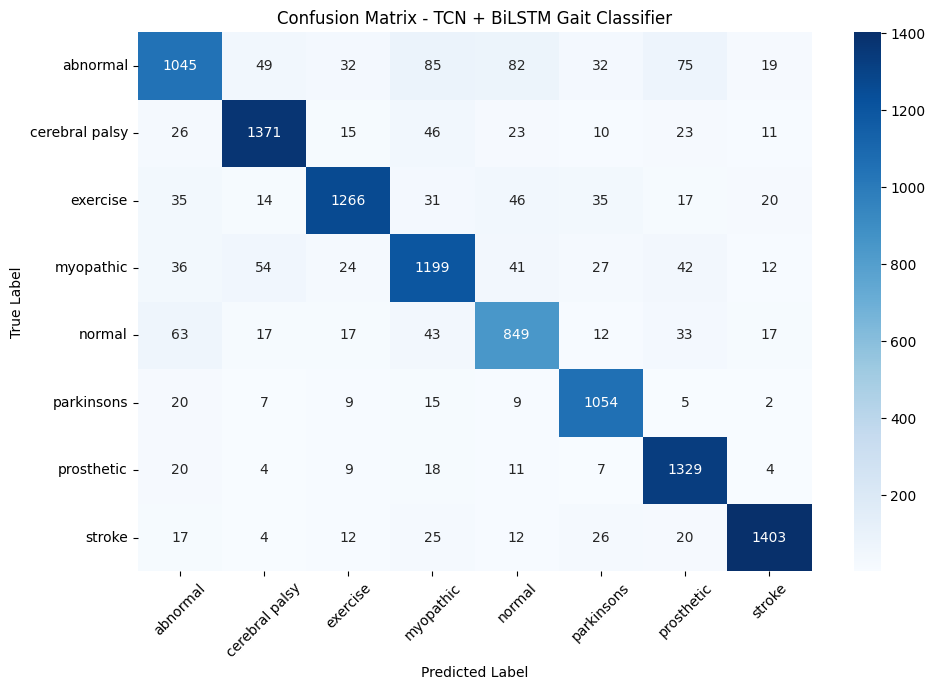

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Reload the best saved model
model = TCNBiLSTMClassifier(input_size=99, num_classes=len(label2id)).to(device)
model.load_state_dict(torch.load("/kaggle/working/best_tcn_bilstm.pth"))
model.eval()

# ✅ Run on test set
_, test_acc, test_preds, test_labels = eval_epoch(model, test_loader)


# ✅ Compute Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in range(len(id2label))],
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TCN + BiLSTM Gait Classifier")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ✅ Transformer-Based Gait Classifier
class TransformerGaitClassifier(nn.Module):
    def __init__(self, input_dim=99, seq_len=5, num_classes=8, d_model=128, nhead=4, num_layers=2, dropout=0.3):
        super(TransformerGaitClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)          # [B, T, d_model]
        x = self.transformer(x)        # [B, T, d_model]
        x = x.mean(dim=1)              # Global average pooling
        return self.fc(x)

# ✅ Dataset Class
class GAVDDataset(Dataset):
    def __init__(self, csv_path, label2id):
        self.df = pd.read_csv(csv_path)
        self.label2id = label2id

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = torch.tensor(ast.literal_eval(row['sequence']), dtype=torch.float32)
        label = self.label2id[row['gait_pat']]
        return sequence, torch.tensor(label, dtype=torch.long)

# ✅ Label Mapping
def create_label_mapping(df):
    label2id = {label: idx for idx, label in enumerate(sorted(df['gait_pat'].unique()))}
    return label2id

# ✅ Paths
train_csv = '/kaggle/input/gavd-seq-split/GAVD_train_sequences.csv'
val_csv = '/kaggle/input/gavd-seq-split/GAVD_val_sequences.csv'
test_csv = '/kaggle/input/gavd-seq-split/GAVD_test_sequences.csv'

label2id = create_label_mapping(pd.read_csv(train_csv))
id2label = {v: k for k, v in label2id.items()}

train_loader = DataLoader(GAVDDataset(train_csv, label2id), batch_size=64, shuffle=True)
val_loader = DataLoader(GAVDDataset(val_csv, label2id), batch_size=64, shuffle=False)
test_loader = DataLoader(GAVDDataset(test_csv, label2id), batch_size=64, shuffle=False)

# ✅ Model, Loss, Optimizer
model = TransformerGaitClassifier(input_dim=99, num_classes=len(label2id)).to(device)

all_labels = [label2id[y] for y in pd.read_csv(train_csv)['gait_pat']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)


# ✅ Training Functions
def train_epoch(model, loader):
    model.train()
    total_loss, preds, labels = 0, [], []
    for x, y in tqdm(loader, desc="🔁 Training"):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds += out.argmax(1).cpu().tolist()
        labels += y.cpu().tolist()
    return total_loss/len(loader), accuracy_score(labels, preds)

def eval_epoch(model, loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for x, y in tqdm(loader, desc="🔍 Evaluating"):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item()
            preds += out.argmax(1).cpu().tolist()
            labels += y.cpu().tolist()
    return total_loss/len(loader), accuracy_score(labels, preds), preds, labels

# ✅ Training Loop
best_acc = 0
patience = 0
for epoch in range(1, 16):
    train_loss, train_acc = train_epoch(model, train_loader)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader)
    print(f"Epoch {epoch:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    scheduler.step(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_transformer_model.pth")
        print("✅ Best model saved.")
        patience = 0
    else:
        patience += 1
        if patience == 5:
            print("🛑 Early stopping.")
            break

# ✅ Test Evaluation
model.load_state_dict(torch.load("/kaggle/working/best_transformer_model.pth"))
_, test_acc, test_preds, test_labels = eval_epoch(model, test_loader)

# ✅ Final Metrics
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print("📋 Classification Report:")
print(classification_report(test_labels, test_preds, target_names=[id2label[i] for i in range(len(id2label))]))
print(f"⚖️ Balanced Accuracy: {balanced_accuracy_score(test_labels, test_preds):.4f}")
print(f"📊 MCC: {matthews_corrcoef(test_labels, test_preds):.4f}")
print(f"🧮 Cohen’s Kappa: {cohen_kappa_score(test_labels, test_preds):.4f}")


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.22it/s]


Epoch 01 | Train Acc: 0.5549 | Val Acc: 0.7422
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.20it/s]


Epoch 02 | Train Acc: 0.7594 | Val Acc: 0.8087
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.18it/s]


Epoch 03 | Train Acc: 0.8225 | Val Acc: 0.8681
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.22it/s]


Epoch 04 | Train Acc: 0.8587 | Val Acc: 0.8794
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.14it/s]


Epoch 05 | Train Acc: 0.8839 | Val Acc: 0.9076
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.18it/s]


Epoch 06 | Train Acc: 0.8971 | Val Acc: 0.9057


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.36it/s]


Epoch 07 | Train Acc: 0.9109 | Val Acc: 0.9343
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.24it/s]


Epoch 08 | Train Acc: 0.9212 | Val Acc: 0.9200


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.24it/s]


Epoch 09 | Train Acc: 0.9286 | Val Acc: 0.9327


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.26it/s]


Epoch 10 | Train Acc: 0.9367 | Val Acc: 0.9468
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.16it/s]


Epoch 11 | Train Acc: 0.9414 | Val Acc: 0.9173


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.33it/s]


Epoch 12 | Train Acc: 0.9442 | Val Acc: 0.9580
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.15it/s]


Epoch 13 | Train Acc: 0.9494 | Val Acc: 0.9556


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.26it/s]


Epoch 14 | Train Acc: 0.9489 | Val Acc: 0.9550


🔍 Evaluating: 100%|██████████| 171/171 [00:14<00:00, 11.47it/s]


Epoch 15 | Train Acc: 0.9568 | Val Acc: 0.9610
✅ Best model saved.


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.30it/s]


✅ Test Accuracy: 0.9572
📋 Classification Report:
                precision    recall  f1-score   support

      abnormal       0.94      0.90      0.92      1419
cerebral palsy       0.97      0.94      0.95      1525
      exercise       0.96      0.98      0.97      1464
     myopathic       0.94      0.95      0.95      1435
        normal       0.94      0.93      0.93      1051
    parkinsons       0.96      0.98      0.97      1121
    prosthetic       0.97      0.99      0.98      1402
        stroke       0.97      0.99      0.98      1519

      accuracy                           0.96     10936
     macro avg       0.96      0.96      0.96     10936
  weighted avg       0.96      0.96      0.96     10936

⚖️ Balanced Accuracy: 0.9568
📊 MCC: 0.9510
🧮 Cohen’s Kappa: 0.9510


🔍 Evaluating: 100%|██████████| 171/171 [00:15<00:00, 11.24it/s]


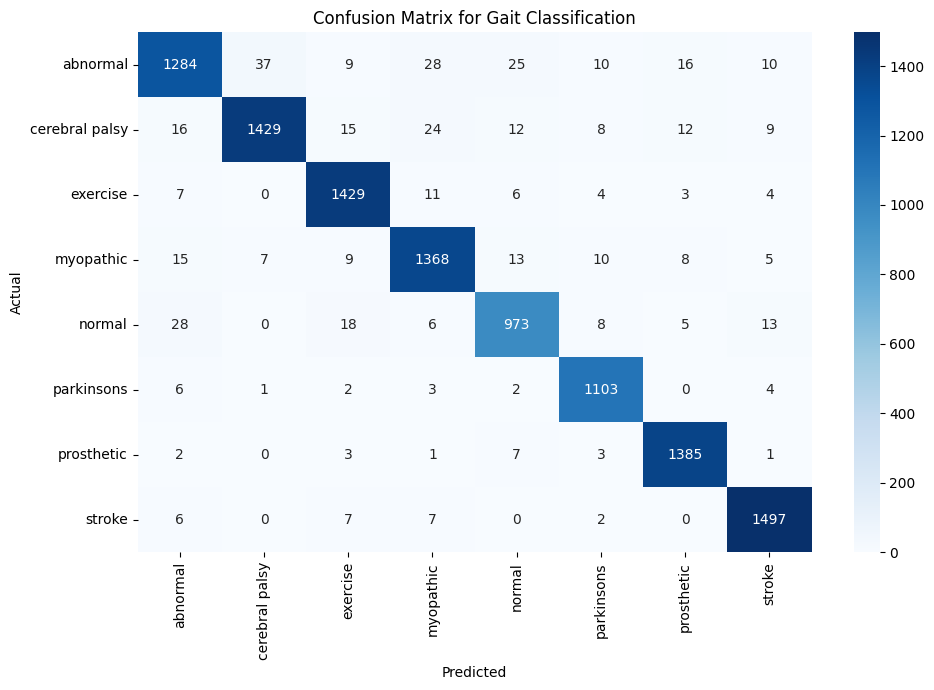

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# ✅ Run on test set
_, test_acc, test_preds, test_labels = eval_epoch(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[id2label[i] for i in range(len(id2label))], yticklabels=[id2label[i] for i in range(len(id2label))])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gait Classification')
plt.tight_layout()
plt.show()


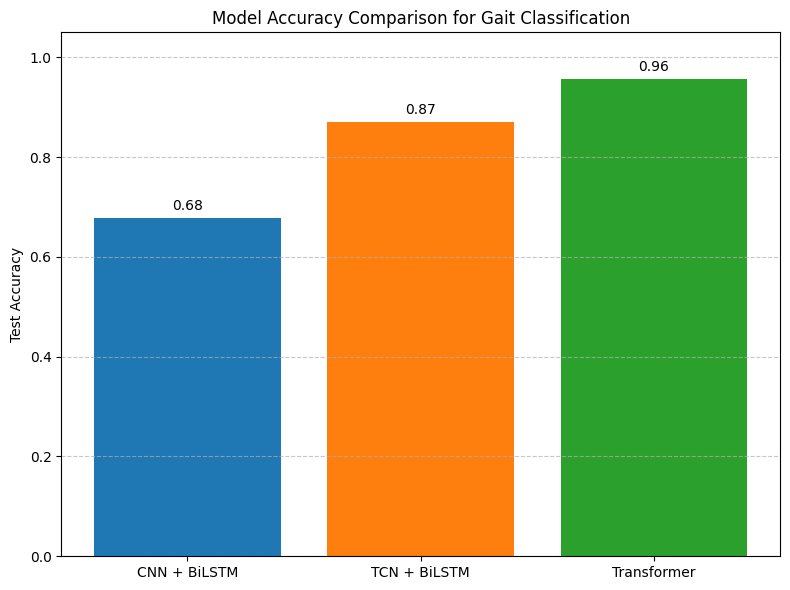

In [12]:
import matplotlib.pyplot as plt

# Model names and corresponding test accuracies
models = ['CNN + BiLSTM', 'TCN + BiLSTM', 'Transformer']
accuracies = [0.6771, 0.8702,  0.9572]

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison for Gait Classification")

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# All key metrics for 3 models
data = {
    "Model": ["CNN + BiLSTM", "TCN + BiLSTM", "Transformer"],
    "Accuracy": [0.6771, 0.8702, 0.9572],
    "Precision": [0.67, 0.87, 0.96],   # macro avg
    "Recall": [0.68, 0.87, 0.96],      # macro avg
    "F1-Score": [0.67, 0.87, 0.96] ,    # macro avg
    "Balanced Accuracy": [0.6766, 0.8694, 0.9568],
    "MCC": [0.6309, 0.8516, 0.9510],
    "Cohen's Kappa": [0.6305, 0.8513, 0.9510],
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

# Optionally, save as CSV
df.to_csv("model_comparison_all_metrics.csv", index=False)

          Model  Accuracy  Precision  Recall  F1-Score  Balanced Accuracy  \
0  CNN + BiLSTM    0.6771       0.67    0.68      0.67             0.6766   
1  TCN + BiLSTM    0.8702       0.87    0.87      0.87             0.8694   
2   Transformer    0.9572       0.96    0.96      0.96             0.9568   

      MCC  Cohen's Kappa  
0  0.6309         0.6305  
1  0.8516         0.8513  
2  0.9510         0.9510  
